# Домашнее задание 6: классификация текстов

В этом домашнем задании вам предстоит построить классификатор текстов!

Данные мы будем использовать из Kaggle соревнования: https://www.kaggle.com/competitions/nlp-getting-started/data


Оттуда надо скачать файл train.csv. На обучающую и тестовую выборки его поделим кодом ниже, менять его не надо!

Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [ ]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [ ]:
data = pd.read_csv('train.csv')

In [ ]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

## Задание 1 (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [ ]:
pd.isnull(data).values.any() # есть пропуски, заполним их пустой строкой

True

In [ ]:
data = data.fillna("")

In [ ]:
train, test = train_test_split(data, test_size=0.3, random_state=42)

In [ ]:
pd.isnull(train).values.any()

False

## Задание 2 (1 балл)
Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Какое распределение классов в обучающей выборке?


In [ ]:
len(train[train['target'] == 0])

3024

In [ ]:
len(train[train['target'] == 1])

2305

-----
-----

Вывод: 3024 > 2305, следовательно, в обучающей выборке больше твиттов, где не содержится информация о катастрофе.

-----
-----

2. Посмотрите на колонку "keyword" - возьмите 10 наиболее встречающихся значений, постройте ступенчатую диаграмму распределения классов в зависимости от значения keyword, сделайте выводы.

In [ ]:
popular_keywords = data['keyword'].value_counts().nlargest(11).to_frame()
popular_keywords

,keyword
,61
fatalities,45
deluge,42
armageddon,42
sinking,41
damage,41
harm,41
body%20bags,41
evacuate,40
fear,40


In [ ]:
data_ten_keywords = data[data.keyword.isin(list(popular_keywords.index.values))]

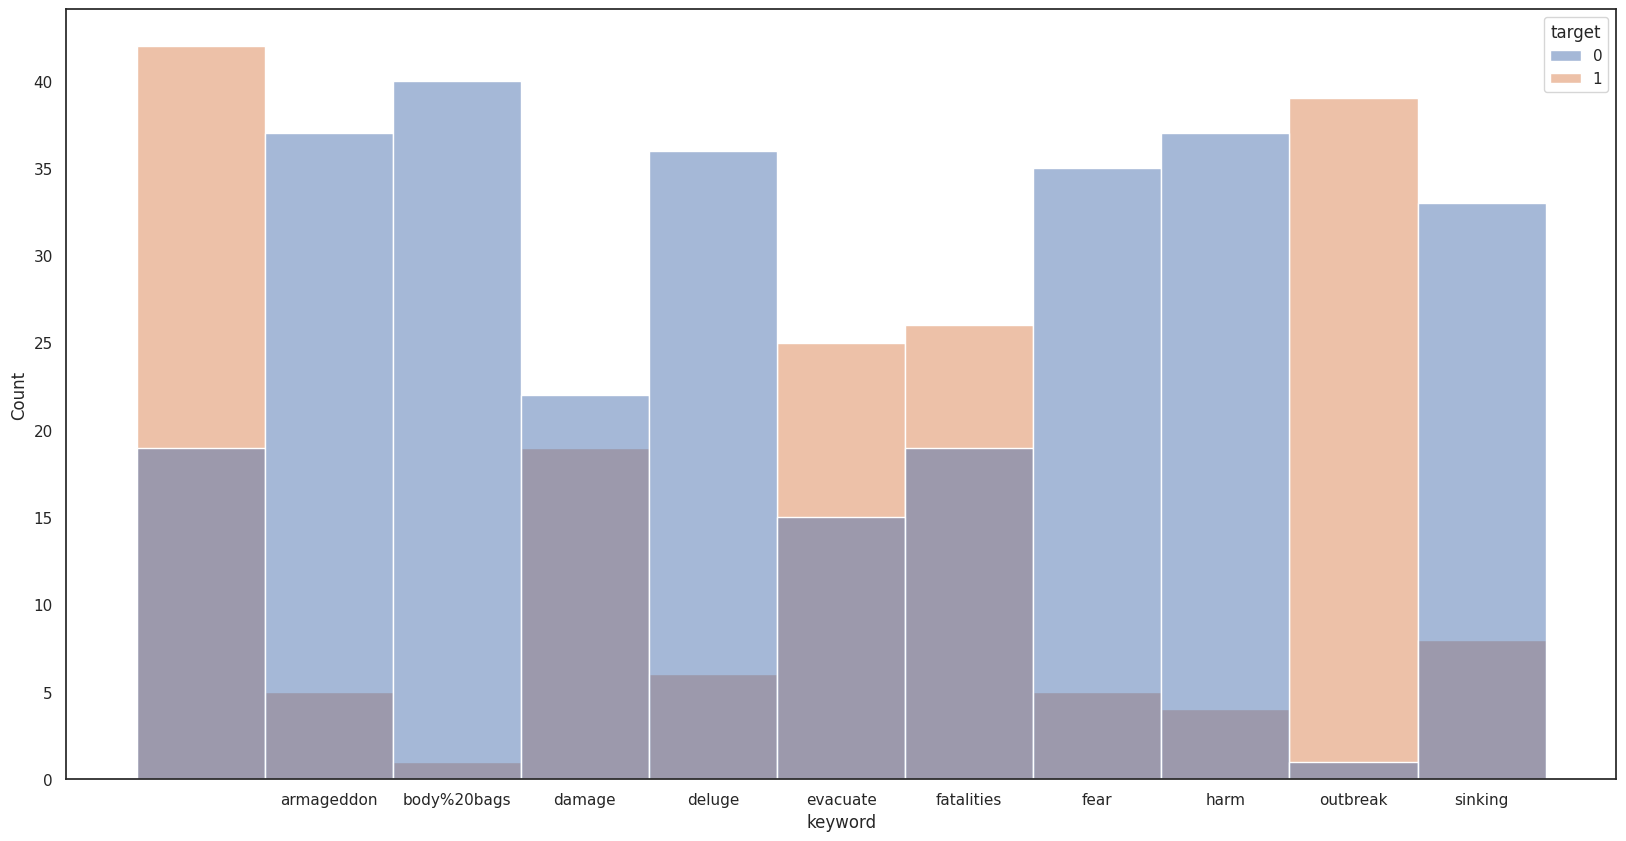

In [ ]:
sns.histplot(data=data_ten_keywords, x="keyword", hue="target")
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white',
            'figure.figsize':( 20, 10 )})
sns.set_style('white')
plt.show() #эту ячейку лучше запустить два раза

**Выводы**: если не включать пустые строки в список из 10 наиболее часто встречающихся значений keywords, то получается, что наличие слов "evacuate", "fatalities" и особенно "outbreak" в твитте указывает на то, что этот твитт, скорее всего, содержит информацию о настоящей катастрофе.

## Задание 3 (0.5 балла)

В этом задании предлагается объединить все три текстовых столбца в один (просто сконкатенировать cтроки) и убрать столбец с индексом.

In [ ]:
data['keyword'] += (' ')
data['keyword'] += data['location'].map(str)
data['keyword'] += (' ')
data['keyword'] += data['text'].map(str)

In [ ]:
data = data.drop(data.columns[[0, 2, 3]], axis = 1)

In [ ]:
data = data.rename(columns={"keyword": "text"})

In [ ]:
train, test = train_test_split(data, test_size=0.3, random_state=42)

In [ ]:
train.loc[[6590, 7122, 2769]]

,text,target
6590,"survivors Marietta, GA Stemming from my #Cubs ...",1
7122,violent%20storm If you were the NWS wth a rot...,1
2769,devastation Atlanta g.a. http://t.co/Gxgm1T3W0...,0


## Задание 4 (0.5 балла)

Далее мы будем пока работать только с train частью.

1. Предобработайте данные (train часть) с помощью CountVectorizer.
2. Какого размера получилась матрица?


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
vectorizer = CountVectorizer()
train_counts = vectorizer.fit_transform(train.text)
train_counts.shape

(5329, 18455)

**Выводы**: получилась матрица размером 5329x18455

## Задание 5 (1 балл)

В предыдущем пункте у вас должна была получиться достаточно большая матрица.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов, ссылок и прочего мусора.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле vocabulary_ инстанса этого класса. Давайте напишем функцию, которая печает ответы на следующие вопросы:

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось?

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось?

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре?

In [ ]:
def contains_digit(s: str) -> bool:
    # Проверка, содержит ли слово цифры
    numbers_list = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

    null_list = []
    m10 = []

    numbers_set = set(numbers_list)
    new_str = set(s)
    m10 = list(new_str.intersection(numbers_set))

    if m10 == null_list:
      return False
    else:
      return True

def contains_punctuation(s: str) -> bool:
    # Проверка, содержит ли слово пунктуацию
    from string import punctuation

    null_list = []
    m11 = []

    punctuation_set = set(punctuation)
    new_str = set(s)
    m11 = list(new_str.intersection(punctuation_set))

    if m11 == null_list:
      return False
    else:
      return True

def is_hashtag(s: str) -> bool:
    # Проверка, является ли слово хэштегом
    return s[0] == '#'

def is_mention(s: str) -> bool:
    # Проверка, является ли слово упоминанием
    return s[0] == '@'

def investigate_vocabulary(vocabulary):
    new_keys = list(vocabulary.keys())

    print('With digit:      ', sum(map(contains_digit, new_keys))
          )
    print('With punctuation:', sum(map(contains_punctuation, new_keys))
          )
    print('Hashtags:        ', sum(map(is_hashtag, new_keys))
          )
    print('Mentions:        ', sum(map(is_mention, new_keys))
          )

In [ ]:
dummy_vocab = {'th1nk' : 0,
               'think333' : 1,
               'think.' : 2,
               'th!nk' : 3,
               'th...nk' : 4,
               '#think' : 5,
               '@think' : 6,
               '@thinking':7,
               '@nothink' : 8,
               'think' : 9}
investigate_vocabulary(dummy_vocab)

With digit:       2
With punctuation: 7
Hashtags:         1
Mentions:         3


In [ ]:
investigate_vocabulary(vectorizer.vocabulary_
                       )

With digit:       3812
With punctuation: 315
Hashtags:         0
Mentions:         0


-----
-----

Вывод: функция investigate_vocabulary() реализована верно, однако при анализе vectorizer.vocabulary_ не учитываются хэштеги и упоминания.

-----
-----

## Задание 6 (0.5 балла)

Вспомним, что на семинаре по текстам мы узнали, что в nltk есть специальный токенизатор для текстов - TweetTokenizer. Попробуем применить CountVectorizer с этим токенизатором. Ответьте на все вопросы из предыдущего пункта для TweetTokenizer и сравните результаты.

In [ ]:
from nltk.tokenize import TweetTokenizer
from nltk import tokenize

# Чтобы узнать, какие параметры есть у этого токенайзера - используйте help(TweetTokenizer)
# Для того, чтобы передать токенайзер в CountVectorizer используйте параметр tokenizer

In [ ]:
def tknz(text):
	tw = TweetTokenizer()
	return tw.tokenize(text)
cnt_vec10 = CountVectorizer(tokenizer=tknz)
a10 = cnt_vec10.fit_transform(train.text)
print(a10.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(5329, 19670)


In [ ]:
investigate_vocabulary(cnt_vec10.vocabulary_
                       )

With digit:       3939
With punctuation: 7338
Hashtags:         1470
Mentions:         1679


**Сравнение:** при сохранении количества строк в матрице количество призаков (слов) увеличилось на 19670 - 18455 = 1215. Также стали учитываться хэштеги и упоминания, немного увеличилось количество слов, содержащих цифры, и значительно увеличилось количество слов, содержащих пунктуацию.

## Задание 7 (2 балла)

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно:

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
4. Проведет стемминг с помощью SnowballStemmer



In [ ]:
def contains_only_latin_letters(s: str) -> bool:
    # Проверка, содержит ли слово только латинские буквы
    from string import punctuation

    punctuation_set = set(punctuation)
    numbers_set = set(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
    set_s = set(s)
    null_set = set()

    if (s.isascii() == True) and (
        set_s.intersection(punctuation_set) == null_set) and (
            set_s.intersection(numbers_set) == null_set):
      return True
    else:
      return False

def is_emoji(s: str) -> bool:
    # Проверка, является ли слово смайликом
    from string import punctuation

    punctuation_set = set(punctuation)
    new_str = set(s)
    m12 = set(new_str.intersection(punctuation_set))

    if (('(' in new_str) or (')' in new_str)) and (
        m12.issubset(punctuation_set) == True):
      return True
    else:
      return False

def is_hashtag(s: str) -> bool:
    # Проверка, является ли слово хэштегом
    return ((s[0] == '#') and (s[1:].isascii() == True))

def custom_tokenizer(s: str) -> List[str]:
    # Кастомный токенайзер
    from nltk.tokenize import TweetTokenizer
    from nltk.stem.snowball import SnowballStemmer
    import nltk
    nltk.download('stopwords')

    string_new = [s.lower()]
    string_new = ''.join(string_new)
    tk = TweetTokenizer()
    string_new = tk.tokenize(string_new)

    text_t = [w for w in string_new if (((contains_only_latin_letters(''.join(w)) == True) or (is_emoji(''.join(w)) == True) or (is_hashtag(''.join(w)) == True)) and (''.join(w) not in nltk.corpus.stopwords.words('english')))]

    stemmer = SnowballStemmer("english")
    return [stemmer.stem(w) for w in text_t]

In [ ]:
custom_tokenizer('She LOVES painting :-) #art')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['love', 'paint', ':-)', '#art']

In [ ]:
custom_tokenizer('She LOVES painting :-) #art')

['love', 'paint', ':-)', '#art']

Продемонстрируйте работу вашей функции на первых десяти текстах в обучающей выборке.

In [ ]:
custom_tokenizer(''.join(data.text[0:10]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['deed',
 'reason',
 '#earthquak',
 'may',
 'allah',
 'forgiv',
 'us',
 'forest',
 'fire',
 'near',
 'la',
 'rong',
 'sask',
 'canada',
 'resid',
 'ask',
 'shelter',
 'place',
 'notifi',
 'offic',
 'evacu',
 'shelter',
 'place',
 'order',
 'expect',
 'peopl',
 'receiv',
 '#wildfir',
 'evacu',
 'order',
 'california',
 'got',
 'sent',
 'photo',
 'rubi',
 '#alaska',
 'smoke',
 '#wildfir',
 'pour',
 'school',
 '#rockyfir',
 'updat',
 'california',
 'hwi',
 'close',
 'direct',
 'due',
 'lake',
 'counti',
 'fire',
 '#cafir',
 '#wildfir',
 '#flood',
 '#disast',
 'heavi',
 'rain',
 'caus',
 'flash',
 'flood',
 'street',
 'manitou',
 'colorado',
 'spring',
 'area',
 'top',
 'hill',
 'see',
 'fire',
 'wood',
 'emerg',
 'evacu',
 'happen',
 'build',
 'across',
 'street',
 'afraid',
 'tornado',
 'come',
 'area']

## Задание 8 (1 балл)

1. Примените CountVectorizer с реализованным выше токенизатором к обучающим и тестовым выборкам.


In [ ]:
vectorizer = CountVectorizer(tokenizer=custom_tokenizer
                             )
bow = vectorizer.fit_transform(train.text)
bow_test = vectorizer.transform(test.text)
bow

Выходные данные были обрезаны до нескольких последних строк (5000).
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is 

<5329x10604 sparse matrix of type '<class 'numpy.int64'>'
	with 51115 stored elements in Compressed Sparse Row format>

In [ ]:
bow.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
pd.DataFrame(bow.toarray(), columns=vectorizer.get_feature_names_out())

,#,##youtub,#034,#039,#06,#09,#1-1st,#1008pla,#140,#163,...,zip,zipper,zmne,zombi,zone,zonewolf,zouma,zss,zumiez,zzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5324,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5325,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5326,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5327,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
bow_test.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
pd.DataFrame(bow_test.toarray(), columns=vectorizer.get_feature_names_out())

,#,##youtub,#034,#039,#06,#09,#1-1st,#1008pla,#140,#163,...,zip,zipper,zmne,zombi,zone,zonewolf,zouma,zss,zumiez,zzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2279,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2280,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2281,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2282,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


-----
-----

Размеры матриц для тренировочной выборки и тестовой:
5329x10604 и 2284x10604 соответственно.

-----
-----

In [ ]:
from sklearn.preprocessing import MaxAbsScaler

vectorizer = CountVectorizer(tokenizer=custom_tokenizer
                             )
bow = vectorizer.fit_transform(train.text)
bow_test = vectorizer.transform(test.text)

scaler = MaxAbsScaler()
bow = scaler.fit_transform(bow)
bow_test = scaler.transform(bow_test)

Выходные данные были обрезаны до нескольких последних строк (5000).
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is 

2. Обучите LogisticRegression на полученных признаках.


In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(bow, train.target)

pred_t = clf.predict(bow_test)

3. Посчитайте метрику f1-score на тестовых данных.

In [ ]:
from sklearn.metrics import f1_score

f1_score(test.target, pred_t)

0.7427937915742794

## Задание 9 (1 балл)

1. Повторите 8 задание, но с tf-idf векторизатором. Как изменилось качество?


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 1
tfidf_vec = TfidfVectorizer(tokenizer=custom_tokenizer)
bow10 = tfidf_vec.fit_transform(train.text);
bow_test10 = tfidf_vec.transform(test.text);

scaler = MaxAbsScaler()
bow10 = scaler.fit_transform(bow10)
bow_test10 = scaler.transform(bow_test10)

clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(bow10, train.target);
pred_t10 = clf.predict(bow_test10);
print(bow10.toarray().shape)
print(bow_test10.toarray().shape)
f1_score(test.target, pred_t10)

Выходные данные были обрезаны до нескольких последних строк (5000).
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is 

(5329, 10604)
(2284, 10604)


0.747276688453159

1. **Ответ:** Размеры матриц для тренировочной выборки и тестовой:
5329x10604 и 2284x10604 соответственно, F1 score: 0.7473.
Таким образом, количество слов не изменилось, качество, судя по значению F1 score (0.7473 > 0.7428), немного улучшилось.

2. Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?


In [ ]:
# 2
tfidf_vec11 = TfidfVectorizer(tokenizer=custom_tokenizer, max_df=0.9);
bow11 = tfidf_vec11.fit_transform(train.text);
bow_test11 = tfidf_vec11.transform(test.text);

scaler = MaxAbsScaler()
bow11 = scaler.fit_transform(bow11)
bow_test11 = scaler.transform(bow_test11)

clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(bow11, train.target);
pred_t11 = clf.predict(bow_test11);
print(bow11.shape)
print(bow_test11.shape)
f1_score(test.target, pred_t11)

Выходные данные были обрезаны до нескольких последних строк (5000).
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is 

(5329, 10604)
(2284, 10604)


0.747276688453159

2. **Ответ:** Размеры матриц для тренировочной выборки и тестовой:
5329x10604 и 2284x10604 соответственно, F1 score: 0.7473.
Таким образом, добавление верхней границы max_df = 0.9 не повлияло ни на размер матриц, ни на значение F1 score. Вероятно, добавление верхней границы действительно не имеет смысла, поскольку custom_tokenizer убирает стоп-слова и, следовательно, не остаётся слов, которые встречаются чаще, чем в 90% текстов.

3. Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df. Удалось ли добиться улучшения качества?

In [ ]:
# 3
tfidf_vec12 = TfidfVectorizer(tokenizer=custom_tokenizer,
                              max_df=0.9, min_df=0.0005);
bow12 = tfidf_vec12.fit_transform(train.text);
bow_test12 = tfidf_vec12.transform(test.text);

scaler = MaxAbsScaler();
bow12 = scaler.fit_transform(bow12);
bow_test12 = scaler.transform(bow_test12);

clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(bow12, train.target);
pred_t12 = clf.predict(bow_test12);
print(bow12.toarray().shape)
print(bow_test12.toarray().shape)
f1_score(test.target, pred_t12)

Выходные данные были обрезаны до нескольких последних строк (5000).
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is 

(5329, 3142)
(2284, 3142)


0.7502714440825191

3. **Ответ:** Размеры матриц при min_df=0.0005 для тренировочной выборки и тестовой:
5329x3142 и 2284x3142 соответственно, F1 score: 0.7503.
Таким образом, добавление нижней границы уменьшило размер матрицы, (поскольку удалились слова, встречающиеся реже, чем в 0.05% случаев) и улучшило качество (0.7503 > 0.7473 > 0.7428). Впрочем, значение F1 score зависит от подбора гиперпараметра: при min_df=0.01 остаётся менее 200 слов, что ухудшает качество, а значение, например, min_df=0.00000000001 будет слишком маленьким для текущего набора данных, поскольку слова не будут убираться и качество не изменится от добавления гиперпараметра.

## Задание 10 (1 балл)

Еще один популяпный трюк, который позволит уменьшить количество признаков называется hashing trick. Его суть в том, то мы случайно группируем признаки ииии  ..... складываем их! А потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Звучит странно, но это отлично работает. Давайте проверим этот трюк в нашем сеттинге.
Также при таком подходе вам не нужно хранить словарь token->index, что тоже иногда полезно.

1. Повторите задание 8 с HashingVectorizer, укажите количество фичей равное 5000.


In [ ]:
from sklearn.feature_extraction.text import HashingVectorizer

hash_vec = HashingVectorizer(tokenizer=custom_tokenizer, n_features=5000)
bow13 = hash_vec.fit_transform(train.text);
bow_test13 = hash_vec.transform(test.text);

scaler = MaxAbsScaler()
bow13 = scaler.fit_transform(bow13)
bow_test13 = scaler.transform(bow_test13)

clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(bow13, train.target);
pred_t13 = clf.predict(bow_test13);
print(bow13.toarray().shape)
print(bow_test13.toarray().shape)
print('F1 score:', f1_score(test.target, pred_t13))

Выходные данные были обрезаны до нескольких последних строк (5000).
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is 

(5329, 5000)
(2284, 5000)
F1 score: 0.7321814254859612


2. Какой из подходов показал самый высокий результат?

2. **Ответ:** Размеры матриц при min_df=0.0005 для тренировочной выборки и тестовой:
5329x5000 и 2284x5000 соответственно, F1 score: 0.7322.
Таким образом, качество ухудшилось. Возможно, значение гиперпараметра n_features=5000 не является оптимальным. Интересно, что при n_features=3142 (это число было в предыдущем задании) F1 score снизится ещё сильнее.

-----
-----

2. **Ответ:** Итак, самый высокий результат показал подход #3: применение TfidfVectorizer с параметрами tokenizer=custom_tokenizer, max_df=0.9 и min_df=0.0005.

-----
-----

## Задание 11 (1 балл)

В этом задании нужно добиться f1 меры хотя в 0.75 на тестовых данных.

-----
-----

Приведём в пример подход #3 с самым высоким показателем F1 score (f1 мера: 0.7503 > 0.7500).

-----
-----

In [ ]:
#3
tfidf_vec12 = TfidfVectorizer(tokenizer=custom_tokenizer,
                              max_df=0.9, min_df=0.0005);
bow12 = tfidf_vec12.fit_transform(train.text);
bow_test12 = tfidf_vec12.transform(test.text);

scaler = MaxAbsScaler();
bow12 = scaler.fit_transform(bow12);
bow_test12 = scaler.transform(bow_test12);

clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(bow12, train.target);
pred_t12 = clf.predict(bow_test12);
print(bow12.toarray().shape)
print(bow_test12.toarray().shape)
f1_score(test.target, pred_t12)

Выходные данные были обрезаны до нескольких последних строк (5000).
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is 

(5329, 3142)
(2284, 3142)


0.7502714440825191